<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/Topoloss_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install topoloss

In [ ]:
# @title Define the trainer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

#@title Import stuff
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from topoloss import TopoLoss, LaplacianPyramid
import matplotlib.pyplot as plt

class SimpleNN(nn.Module):
    def __init__(self, hidden_size=128, bias: bool = False):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(28 * 28, self.hidden_size, bias=bias)
        self.fc2 = nn.Linear(self.hidden_size, 10, bias=bias)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    @classmethod
    def from_checkpoint(cls, filename: str, hidden_size=128, bias: bool = False):
        state_dict = torch.load(filename, weights_only=True)
        model = cls(hidden_size=hidden_size, bias=bias)
        model.load_state_dict(state_dict, strict = True)
        return model

class MnistTrainer:
    def __init__(self, device=None):
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')

    def train(self, model, train_dataset, test_dataset, epochs, checkpoint_filename, hyperparameters, topo_loss=None, progress = False):
        """
        Trains the model on the MNIST dataset.

        Args:
            model (torch.nn.Module): The model to train.
            train_dataset (torch.utils.data.Dataset): The training dataset.
            test_dataset (torch.utils.data.Dataset): The testing dataset for evaluation during training.
            epochs (int): Number of epochs to train.
            checkpoint_filename (str): Path to save the model checkpoint.
            hyperparameters (dict): Dictionary of hyperparameters (e.g., batch_size, learning_rate).
        """
        batch_size = hyperparameters.get('batch_size', 64)
        learning_rate = hyperparameters.get('learning_rate', 0.001)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        val_accs = []
        val_accuracy = self.test(model, test_dataset)
        val_accs.append(val_accuracy)

        for epoch in tqdm(range(epochs), disable = not(progress)):
            model.train()
            running_loss = 0.0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if topo_loss is not None:
                    loss += topo_loss.compute(model, reduce_mean=True)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            val_accuracy = self.test(model, test_dataset)
            val_accs.append(val_accuracy)

            if topo_loss is None:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
            else:
                topo = topo_loss.compute(model, reduce_mean=True).item()
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, \033[93mTopo Loss: {topo:.7f}\033[0m, Val Accuracy: {val_accuracy:.4f}")

        torch.save(model.state_dict(), checkpoint_filename)
        print(f"\033[92mModel saved to {checkpoint_filename}\033[0m")
        return model, val_accs

    def test(self, model, val_dataset):
        """
        Tests the model on the validation dataset.

        Args:
            model (torch.nn.Module): The model to test.
            val_dataset (torch.utils.data.Dataset): The validation dataset.

        Returns:
            float: The accuracy of the model on the validation dataset.
        """
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        model = model.to(self.device)
        model.eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy


In [ ]:
#@title Set HyperParameters and initialize the model and the dataset
device = "cuda:0" if torch.cuda.is_available() else "cpu"
hidden_size = 256
epochs = 10
checkpoint_filename = "model.pth"
learning_rate = 0.001
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

trainer = MnistTrainer(device=device)
model = SimpleNN(hidden_size=hidden_size).to(device=device)

In [ ]:
#@title Define TopoLoss parameters 👀
topo_loss = TopoLoss(
    # factor_h and factor_w are the downsample factors \phi as mentioned in the paper
    # scale is the \Tau
    losses=[
        LaplacianPyramid(layer_name="fc1", factor_h = 4, factor_w = 4, scale = 3.0),
        ## you can apply topoloss to more layers by adding stuff in this list
    ]
)
print(topo_loss.compute(model=model))

tensor(2.6287, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
#@title Train the model
model, val_accs = trainer.train(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    epochs=epochs,
    checkpoint_filename=checkpoint_filename,
    hyperparameters={"batch_size": batch_size, "learning_rate": learning_rate},
    topo_loss=topo_loss, ## set this to None to see what happens when we train without TopoLoss
)

Epoch [1/10], Loss: 0.6360, Topo Loss: 0.0619490, Val Accuracy: 0.9279
Epoch [2/10], Loss: 0.2657, Topo Loss: 0.0434901, Val Accuracy: 0.9503
Epoch [3/10], Loss: 0.2145, Topo Loss: 0.0391973, Val Accuracy: 0.9531
Epoch [4/10], Loss: 0.1906, Topo Loss: 0.0385707, Val Accuracy: 0.9522
Epoch [5/10], Loss: 0.1770, Topo Loss: 0.0380123, Val Accuracy: 0.9557
Epoch [6/10], Loss: 0.1628, Topo Loss: 0.0378231, Val Accuracy: 0.9570
Epoch [7/10], Loss: 0.1542, Topo Loss: 0.0351902, Val Accuracy: 0.9642
Epoch [8/10], Loss: 0.1490, Topo Loss: 0.0368067, Val Accuracy: 0.9614
Epoch [9/10], Loss: 0.1422, Topo Loss: 0.0345855, Val Accuracy: 0.9682
Epoch [10/10], Loss: 0.1374, Topo Loss: 0.0339060, Val Accuracy: 0.9668
Model saved to model.pth


In [ ]:
from topoloss.cortical_sheet.output import get_cortical_sheet_linear
model = SimpleNN.from_checkpoint(hidden_size=hidden_size, filename = checkpoint_filename).eval()

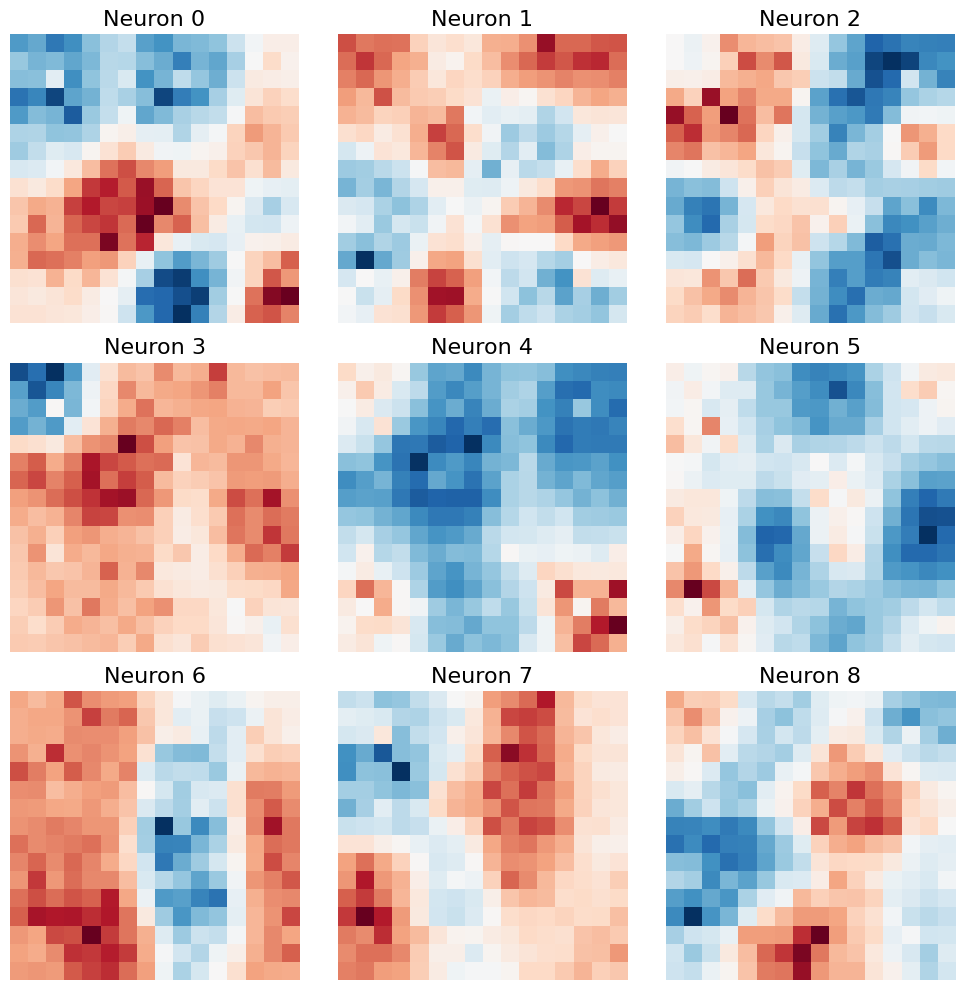

In [ ]:
#@title Visualizing the structure of raw weights

# cortical_sheet: height, width, in_features
# height * width = out_features
cortical_sheet = get_cortical_sheet_linear(
    layer=model.fc1
).cpu().detach()

# Set up the 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, ax in enumerate(axes.flat):
    ax.imshow(cortical_sheet[:, :, idx], cmap="RdBu")
    ax.set_title(f"Neuron {idx}", fontsize= 16)
    ax.axis("off")  # Optional: turn off the axis for cleaner visualization
    # plt.colorbar(ax.imshow(cortical_sheet[:, :, idx], cmap="RdBu"), ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()

# Orientation Selectivity experiment

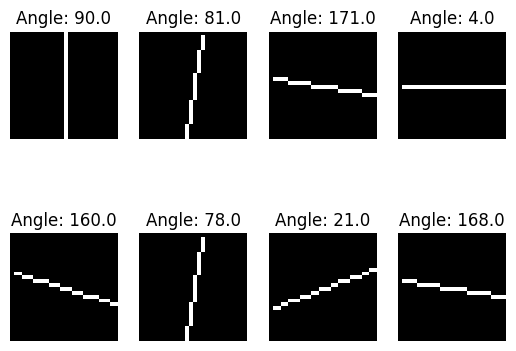

In [ ]:
#@title Dataset containing lines of diffrent orientations
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt

class LineOrientationDataset(Dataset):
    def __init__(self, image_size=28, num_orientations=360):
        self.image_size = image_size
        self.num_orientations = num_orientations
        self.orientations = np.linspace(0, 180, num_orientations, endpoint=False)

    def __len__(self):
        return self.num_orientations

    def __getitem__(self, idx):
        angle = self.orientations[idx]
        image = self._generate_image(angle)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(angle, dtype=torch.float32)

    def _generate_image(self, angle):
        """Generate a 28x28 image with a white line at the given angle."""
        image = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        center = self.image_size // 2
        length = self.image_size // 2

        # Convert angle to radians
        theta = math.radians(angle)

        # Calculate line endpoints
        x1 = center + int(length * math.cos(theta))
        y1 = center - int(length * math.sin(theta))
        x2 = center - int(length * math.cos(theta))
        y2 = center + int(length * math.sin(theta))

        # Draw the line using Bresenham's algorithm
        rr, cc = self._bresenham_line(center, center, x1, y1)
        image[rr, cc] = 1.0

        rr, cc = self._bresenham_line(center, center, x2, y2)
        image[rr, cc] = 1.0

        return image

    def _bresenham_line(self, x0, y0, x1, y1):
        """Bresenham's line algorithm for generating line coordinates."""
        points = []
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        while True:
            points.append((y0, x0))
            if x0 == x1 and y0 == y1:
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x0 += sx
            if e2 < dx:
                err += dx
                y0 += sy

        # Separate the points into row and column indices
        rr, cc = zip(*points)
        return np.clip(np.array(rr), 0, self.image_size - 1), np.clip(np.array(cc), 0, self.image_size - 1)

class ForwardHook:
    def __init__(self, module):
        """
        a nice forward hook
        """
        self.hook = module.register_forward_hook(self.hook_fn)
        self.input = None
        self.output = None

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

orientation_dataset = LineOrientationDataset(num_orientations = 180)
dataloader = DataLoader(orientation_dataset, batch_size=32, shuffle=True)

# Display some examples
for images, angles in dataloader:
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy(), cmap="gray")
        plt.title(f"Angle: {angles[i].item():.1f}")
        plt.axis("off")
    plt.show()
    break

In [ ]:
#@title Collect model responses for lines of different orientations
model.to(device)
hook = ForwardHook(module=model.fc1)

hook_outputs = []
all_orientations = []
for batch in dataloader:
    images, orientations = batch
    logits = model(images.to(device))
    all_orientations.append(orientations)
    hook_outputs.append(hook.output)

hook_outputs = torch.cat(hook_outputs, dim = 0)
all_orientations = torch.cat(all_orientations, dim =0)

In [ ]:
#@title Define utility to analyse orientation selectivity of each neuron

import torch
import math

def eval_orientation_selectivity_all_neurons_tvals(hook_outputs, all_orientations, target_angle: float, tolerance=3):
    # Mask for target orientations within the tolerance range
    mask = torch.logical_and(
        (all_orientations <= target_angle + tolerance),
        (target_angle - tolerance <= all_orientations)
    )

    # Get the outputs corresponding to the target orientations
    target_outputs = hook_outputs[mask]

    # Get the outputs corresponding to the other orientations
    other_outputs = hook_outputs[~mask]

    # Ensure we have valid data for computation
    if target_outputs.size(0) < 2 or other_outputs.size(0) < 2:
        raise ValueError("Not enough data points for t-test computation")

    # Compute mean and standard deviation for both target and other outputs
    target_mean = target_outputs.mean(dim=0)
    other_mean = other_outputs.mean(dim=0)
    target_std = target_outputs.std(dim=0, unbiased=False)  # Standard deviation for population
    other_std = other_outputs.std(dim=0, unbiased=False)

    # Number of samples in each group
    target_n = target_outputs.size(0)
    other_n = other_outputs.size(0)

    # Compute pooled standard deviation
    pooled_std = torch.sqrt(((target_n - 1) * target_std**2 + (other_n - 1) * other_std**2) / (target_n + other_n - 2))

    # Compute t-values
    t_values = (target_mean - other_mean) / (pooled_std * math.sqrt(1 / target_n + 1 / other_n))

    return t_values.cpu().detach()




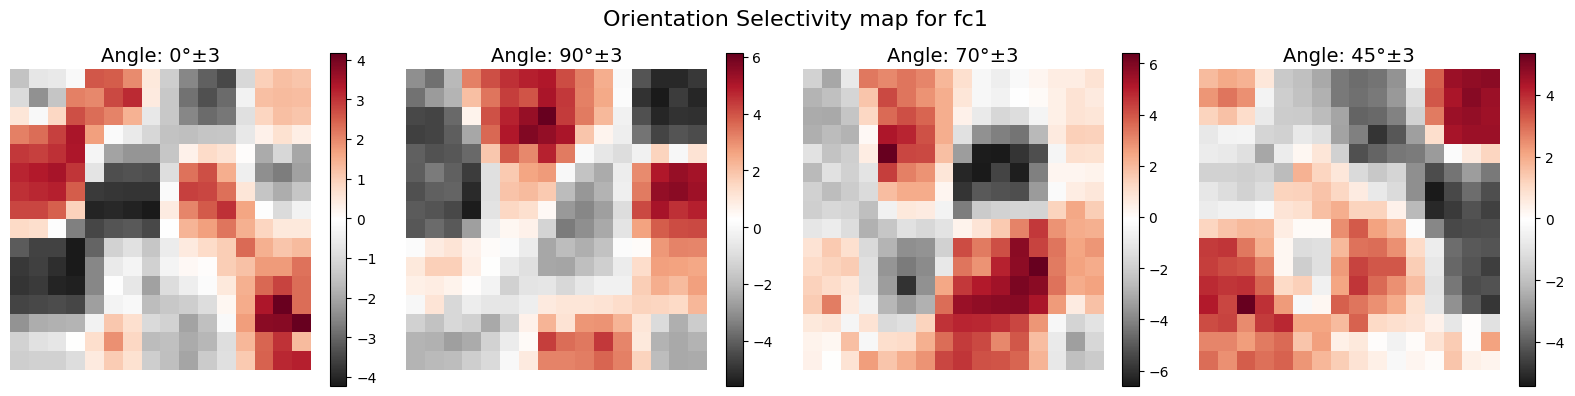

In [ ]:
from topoloss.core import find_cortical_sheet_size
import matplotlib.pyplot as plt

# Define angles for horizontal and vertical lines
target_angles = [0, 90, 70, 45]  # 0 for horizontal, 90 for vertical
tolerance = 3

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, len(target_angles), figsize=(16, 4))  # 1 row, 2 columns
fig.suptitle("Orientation Selectivity map for fc1", fontsize =16)
for idx, target_angle in enumerate(target_angles):
    tvals = eval_orientation_selectivity_all_neurons_tvals(hook_outputs, all_orientations, target_angle=target_angle, tolerance=tolerance)
    size = find_cortical_sheet_size(tvals.shape[0])

    # Reshape tvals for proper display and plot in the corresponding subplot
    ax = axes[idx]
    im = ax.imshow(tvals.reshape(size.height, size.width), cmap="RdGy_r")

    # Remove axes and add titles
    ax.axis('off')
    ax.set_title(f"Angle: {target_angle}°±{tolerance}", fontsize=14, horizontalalignment='center')

    # Add individual colorbars for each subplot
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [ ]:
#@title optional: make a video showing the orientation image and the selectivity map
import imageio
from PIL import Image
import numpy as np

!mkdir -p frames

def generate_video(
    list_of_pil_images: list, framerate: int, filename: str
):

    # Save the resized images as a video using imageio
    imageio.mimwrite(filename, list_of_pil_images, fps=framerate)


num_loops = 0

target_angles = range(0,179)
tolerance = 1
filenames = []
for n in range(num_loops-1):
    target_angles.extend(target_angles)


for idx, target_angle in enumerate(tqdm(target_angles)):
    tvals = eval_orientation_selectivity_all_neurons_tvals(hook_outputs, all_orientations, target_angle=target_angle, tolerance=tolerance)
    size = find_cortical_sheet_size(tvals.shape[0])
    stimulus = orientation_dataset._generate_image(angle=target_angle)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(tvals.reshape(size.height, size.width), cmap="RdGy_r")
    ax[1].imshow(stimulus, cmap = "gray")

    ax[0].axis("off")
    ax[1].axis("off")
    ax[1].set_title(f"Stimulus")
    ax[0].set_title(f"Selectivity\n(t-values)")
    filename =f"frames/{idx}.jpg"
    fig.savefig(filename)
    filenames.append(filename)
    plt.close()
    # break

100%|██████████| 179/179 [00:26<00:00,  6.69it/s]


In [ ]:
generate_video(
    list_of_pil_images = [Image.open(f) for f in filenames],
    framerate=30,
    filename="video.mp4"
)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=900 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)